In [1]:
import numpy as np
import os
import torch

from glob import glob
from skimage import io
from tensorboardX import SummaryWriter
from torch.utils.data.dataloader import DataLoader
from torch import nn
from tqdm import tqdm
from time import time

from src.batch_generator import BatchGenerator, WraptorDataLoader
from src.command import Command
from src.models import LocalTransferNet, GlobalTransferer, RefinementNet
from src.train_utils import (draw_scalar_value, draw_images, rgb2gray, infer_batch, 
                             inference_all_test_videos, load_all_test_videos, calculate_psnr_result, load_video_frames, inference_test_video)


from color_utils import rgb2lab_torch, lab2rgb_torch
def rgb2gray(rgb):
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = (0.2989 * r + 0.5870 * g + 0.1140 * b)[..., None]
    return np.repeat(gray, 3, 2)  

def frame_to_tensor(frame):
    return torch.tensor(frame, dtype=torch.double, requires_grad=False).cuda()

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='6'

In [3]:
global_transferer = GlobalTransferer()
refinement_net = nn.DataParallel(RefinementNet().double().cuda())

## Pretrain local (one frame back vs several frames back)

In [4]:
local_transfer_net_one_back = nn.DataParallel(LocalTransferNet().double().cuda())
local_transfer_net_one_back.load_state_dict(torch.load("experiments/pretrain_local_one_frames_back/checkpoints/2750/local_net_state_dict"))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
local_transfer_net_several_back = nn.DataParallel(LocalTransferNet().double().cuda())
local_transfer_net_several_back.load_state_dict(torch.load("experiments/pretrain_local_several_frames_back_highlr_amsgrad/checkpoints/7800/local_net_state_dict"))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
dataset_dir = "datasets/Davis480/480p/"

In [87]:
test_videos_folders = sorted(glob(dataset_dir + "/*"))[-5:]

In [88]:
test_videos_folders

['datasets/Davis480/480p/stroller',
 'datasets/Davis480/480p/surf',
 'datasets/Davis480/480p/swing',
 'datasets/Davis480/480p/tennis',
 'datasets/Davis480/480p/train']

In [93]:
gt_frames = load_all_test_videos(test_videos_folders, resize_size=(128, 128, 3))
gt_frames = [frames[:30] for frames in gt_frames]

In [ ]:
videos_output_one_back = []
for video_frames in gt_frames:
    _, output_refinement_one_back, _, _ = inference_test_video(video_frames, refinement_net, local_transfer_net_one_back, global_transferer,
                                                                                   use_only_local=True)
    videos_output_one_back.append(output_refinement_one_back)
    
    


 31%|███       | 9/29 [00:44<01:39,  4.99s/it]/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)

 66%|██████▌   | 19/29 [01:36<00:50,  5.09s/it]/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)

 86%|████████▌ | 25/29 [02:04<00:19,  4.99s/it]/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)

 90%|████████▉ | 26/29 [02:09<00:14,  4.98s/it]/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 6 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)

 93%|███████

In [103]:
videos_output_several_back = []
for video_frames in gt_frames:
    _, output_refinement_several_back, _, _ = inference_test_video(video_frames, refinement_net, local_transfer_net_several_back, global_transferer,
                                                                                   use_only_local=True)
    videos_output_several_back.append(output_refinement_several_back)
    
    


100%|██████████| 29/29 [03:12<00:00,  6.64s/it]

100%|██████████| 29/29 [03:07<00:00,  6.47s/it]

100%|██████████| 29/29 [03:10<00:00,  6.56s/it]

100%|██████████| 29/29 [03:16<00:00,  6.76s/it]

100%|██████████| 29/29 [03:03<00:00,  6.31s/it]


In [97]:
import imageio
def make_video_from_frames(output_path, frames):
    writer = imageio.get_writer(output_path, fps=20)
    for im in frames:
        writer.append_data((im * 255).astype(np.uint8))
    writer.close()

In [523]:
show_frames = [0, 1, 10, 20, 29]

In [525]:
gt_show = np.concatenate([gt_frames[-1][i] for i in show_frames], axis=1)
one_back_show = np.concatenate([videos_output_one_back[-1][i] for i in show_frames], axis=1)
several_back_show = np.concatenate([videos_output_several_back[-1][i] for i in show_frames], axis=1)

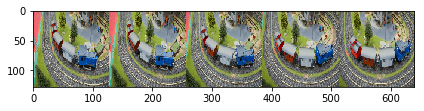

In [526]:
io.imshow(gt_show)

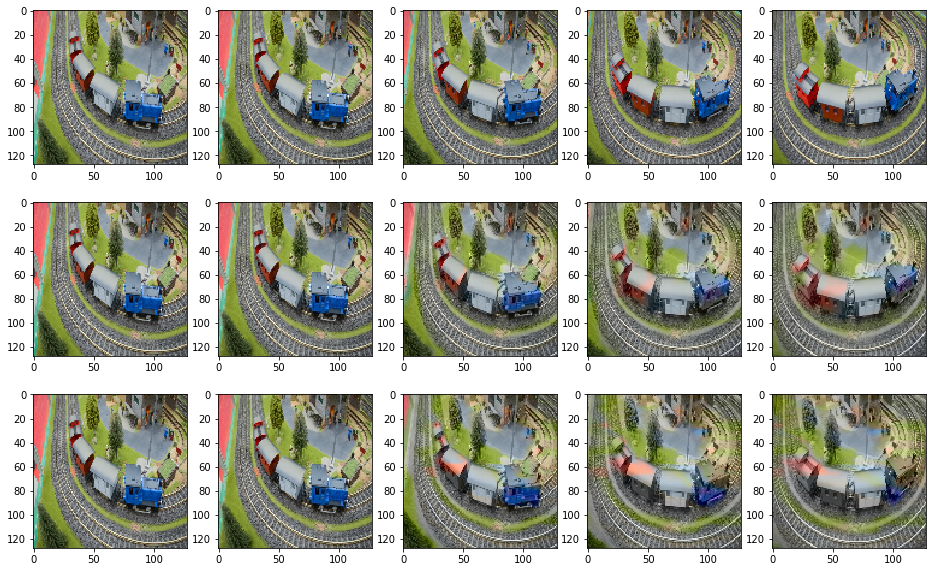

In [493]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, ncols=len(show_frames), figsize=(16, 10))
for i in range(len(show_frames)):
    ax[0][i].imshow(gt_frames[-1][show_frames[i]])
    ax[2][i].imshow(videos_output_one_back[-1][show_frames[i]])
    ax[1][i].imshow(videos_output_several_back[-1][show_frames[i]])
    
    

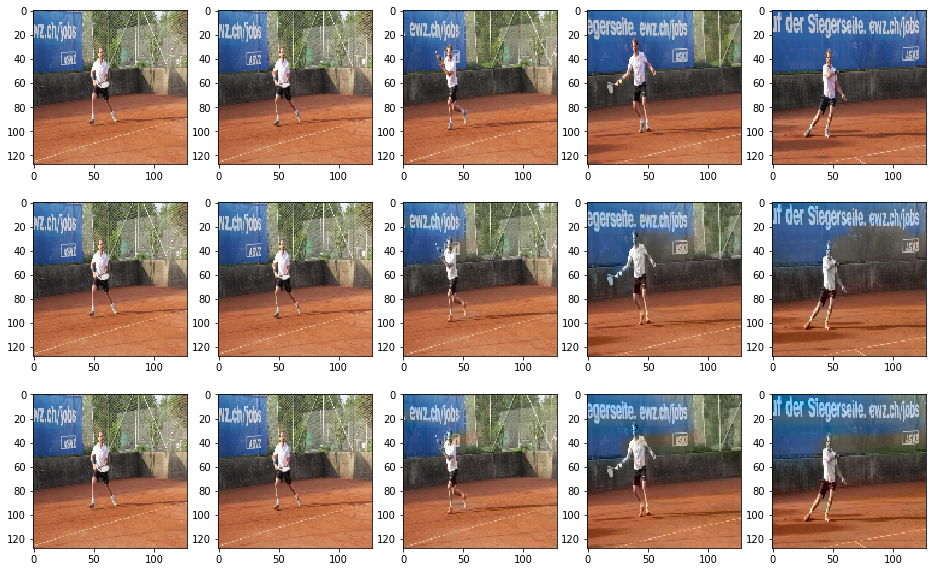

In [84]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, ncols=len(show_frames), figsize=(16, 10))
for i in range(len(show_frames)):
    ax[0][i].imshow(gt_frames[show_frames[i]])
    ax[2][i].imshow(output_refinement_one_back[show_frames[i]])
    ax[1][i].imshow(output_refinement_several_back[show_frames[i]])
    
    

In [74]:
def calculate_psnr_result(rgb_gt_videos, rgb_predicted_videos):
    videos_psnr = []
    for i in range(len(rgb_gt_videos)):
        predicted_frames = rgb_predicted_videos[i][1:]
        gt_frames = rgb_gt_videos[i][1:]
        frames_psnr = []
        for gt, p in zip(gt_frames, predicted_frames):
            #print(rgb2lab(gt).max())
            #gt_lab = 
            frames_psnr.append(compare_psnr(gt, p))
        videos_psnr.append(np.mean(frames_psnr))
    return np.mean(videos_psnr)

In [75]:
from skimage.color import rgb2lab

In [108]:
def calculate_mse_lab_result(rgb_gt_videos, rgb_predicted_videos):
    videos_mse = []
    for i in range(len(rgb_gt_videos)):
        predicted_frames = rgb_predicted_videos[i][1:]
        gt_frames = rgb_gt_videos[i][1:]
        frames_mse = []
        for gt, p in zip(gt_frames, predicted_frames):
            frames_mse.append(-np.mean((rgb2lab(gt)[..., 1:] - rgb2lab(p)[..., 1:])**2))
        videos_mse.append(np.mean(frames_mse))
    return np.mean(videos_mse)

In [125]:
from skimage.measure import compare_psnr
psnr_frames_one_back = []
for i in range(len(gt_frames[0])):
    sliced_gt_frames = [frames[:i + 1] for frames in gt_frames]
    sliced_predicted_frames = [frames[:i + 1] for frames in videos_output_one_back]
    psnr_frames_one_back.append(calculate_psnr_result(sliced_gt_frames, sliced_predicted_frames))

In [126]:
psnr_frames_several_back = []
for i in range(len(gt_frames[0])):
    sliced_gt_frames = [frames[:i + 1] for frames in gt_frames]
    sliced_predicted_frames = [frames[:i + 1] for frames in videos_output_several_back]
    psnr_frames_several_back.append(calculate_psnr_result(sliced_gt_frames, sliced_predicted_frames))

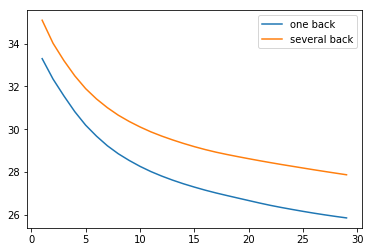

In [127]:
plt.plot(psnr_frames_one_back, label="one back")
plt.plot(psnr_frames_several_back, label="several back")
plt.legend(loc="best")
plt.show()

In [133]:
from tqdm import tqdm_notebook as tqdm
mse_frames_one_back = []
for i in tqdm(range(len(gt_frames[0]))):
    sliced_gt_frames = [frames[:i + 1] for frames in gt_frames]
    sliced_predicted_frames = [frames[:i + 1] for frames in videos_output_one_back]
    mse_frames_one_back.append(calculate_mse_lab_result(sliced_gt_frames, sliced_predicted_frames))

In [134]:
mse_frames_several_back = []
for i in tqdm(range(len(gt_frames[0]))):
    sliced_gt_frames = [frames[:i + 1] for frames in gt_frames]
    sliced_predicted_frames = [frames[:i + 1] for frames in videos_output_several_back]
    mse_frames_several_back.append(calculate_mse_lab_result(sliced_gt_frames, sliced_predicted_frames))

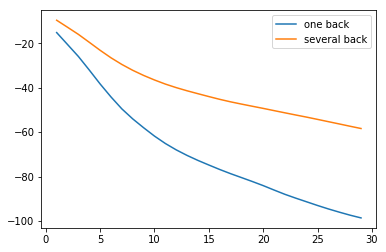

In [135]:
plt.plot(mse_frames_one_back, label="one back")
plt.plot(mse_frames_several_back, label="several back")
plt.legend(loc="best")

## MobileNet vs ResNet

In [136]:
from src.models import GlobalTransferer

In [137]:
global_transferer_mobile = GlobalTransferer(net_type="mobilenet")
global_transferer_resnet = GlobalTransferer(net_type="resnet101")

In [138]:
import numpy as np
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = (0.2989 * r + 0.5870 * g + 0.1140 * b)[..., None]
    return np.repeat(gray, 3, 2)

def downscale_img(img, downscale_times=2):
    h, w = img.shape[:2]
    new_h, new_w = h // downscale_times, w // downscale_times
    return resize(img, (new_h, new_w))

In [139]:
# videos_output_one_back = []
# for video_frames in gt_frames:
#     _, output_refinement_one_back, _, _ = inference_test_video(video_frames, refinement_net, local_transfer_net_one_back, global_transferer,
#                                                                                    use_only_local=True)
#     videos_output_one_back.append(output_refinement_one_back)
    
    

In [368]:
from skimage import img_as_float
from skimage.transform import resize
def get_samples_from_folder(folder, size=168, k=3, start_row=0, start_col=50):
    I1 = img_as_float(io.imread(folder + "/00000.jpg"))
    Ik = img_as_float(io.imread(folder + "/%05d.jpg" % (k)))
    I1 = downscale_img(I1, 3)
    Ik = downscale_img(Ik, 3)
    
    return I1[start_row:start_row + size, start_col : start_col + size], Ik[start_row:start_row + size, start_col : start_col + size]

In [369]:
dir_name = "train"

In [370]:
I1, I3 = get_samples_from_folder("datasets/Davis480/480p/%s" % dir_name)

In [371]:
%%time
result_3_mobilenet = global_transferer_mobile.forward(rgb2gray(I1)[None, ...],
                                      rgb2gray(I3)[None, ...],
                                      I1[None, ...])[0]

CPU times: user 3.59 s, sys: 12 ms, total: 3.6 s
Wall time: 1.4 s


/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 10 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


In [372]:
%%time
result_3_resnet = global_transferer_resnet.forward(rgb2gray(I1)[None, ...],
                                      rgb2gray(I3)[None, ...],
                                      I1[None, ...])[0]

CPU times: user 29.1 s, sys: 91.9 ms, total: 29.1 s
Wall time: 6.1 s


In [373]:
I1, I20 = get_samples_from_folder("datasets/Davis480/480p/%s" % dir_name, k=15)

In [374]:
%%time
result_20_mobilenet = global_transferer_mobile.forward(rgb2gray(I1)[None, ...],
                                      rgb2gray(I20)[None, ...],
                                      I1[None, ...])[0]

CPU times: user 2.94 s, sys: 3.98 ms, total: 2.94 s
Wall time: 1.4 s


/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 48 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


In [375]:
%%time
result_20_resnet = global_transferer_resnet.forward(rgb2gray(I1)[None, ...],
                                      rgb2gray(I20)[None, ...],
                                      I1[None, ...])[0]

CPU times: user 36.5 s, sys: 108 ms, total: 36.6 s
Wall time: 8.81 s


/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 35 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


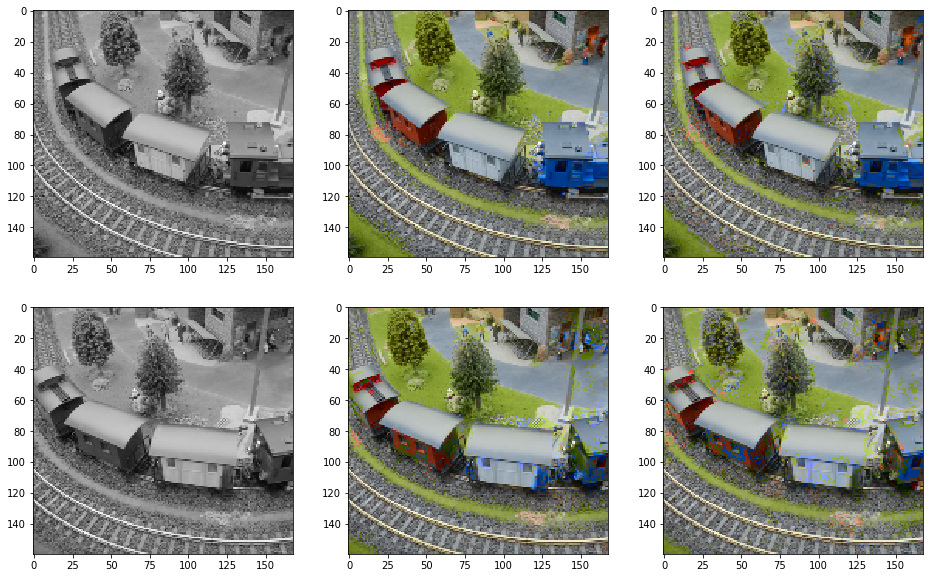

In [376]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
ax[0][0].imshow(rgb2gray(I3))
ax[0][1].imshow(result_3_resnet)
ax[0][2].imshow(result_3_mobilenet)

ax[1][0].imshow(rgb2gray(I20))
ax[1][1].imshow(result_20_resnet)
ax[1][2].imshow(result_20_mobilenet)

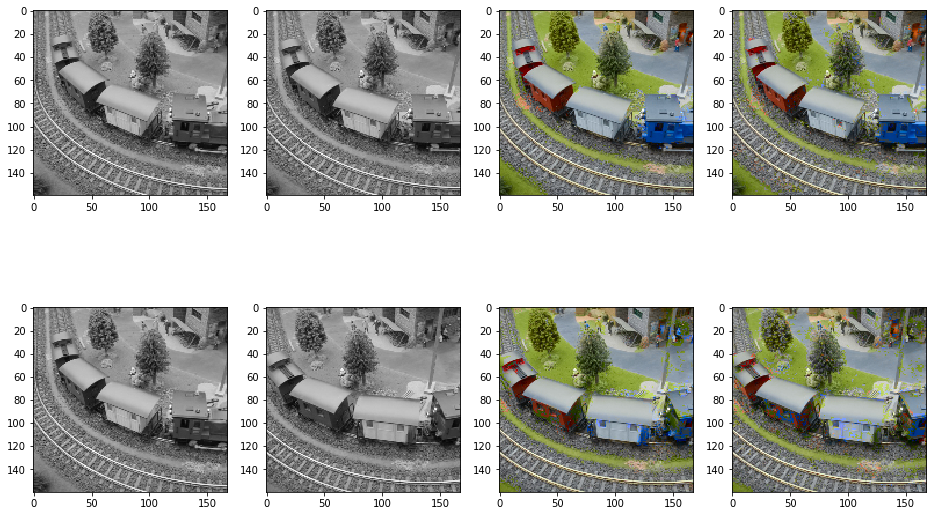

In [377]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))
ax[0][0].imshow(rgb2gray(I1))
ax[0][1].imshow(rgb2gray(I3))
ax[0][2].imshow(result_3_resnet)
ax[0][3].imshow(result_3_mobilenet)

ax[1][0].imshow(rgb2gray(I1))
ax[1][1].imshow(rgb2gray(I20))
ax[1][2].imshow(result_20_resnet)
ax[1][3].imshow(result_20_mobilenet)

In [454]:
io.imsave("for_text/Mobile_vs_Resnet3_train.png", np.concatenate((I1, rgb2gray(I1), rgb2gray(I3), result_3_resnet, result_3_mobilenet), axis=1))
io.imsave("for_text/Mobile_vs_Resnet20_train.png", np.concatenate((I1, rgb2gray(I1), rgb2gray(I20), result_20_resnet, result_20_mobilenet), axis=1))












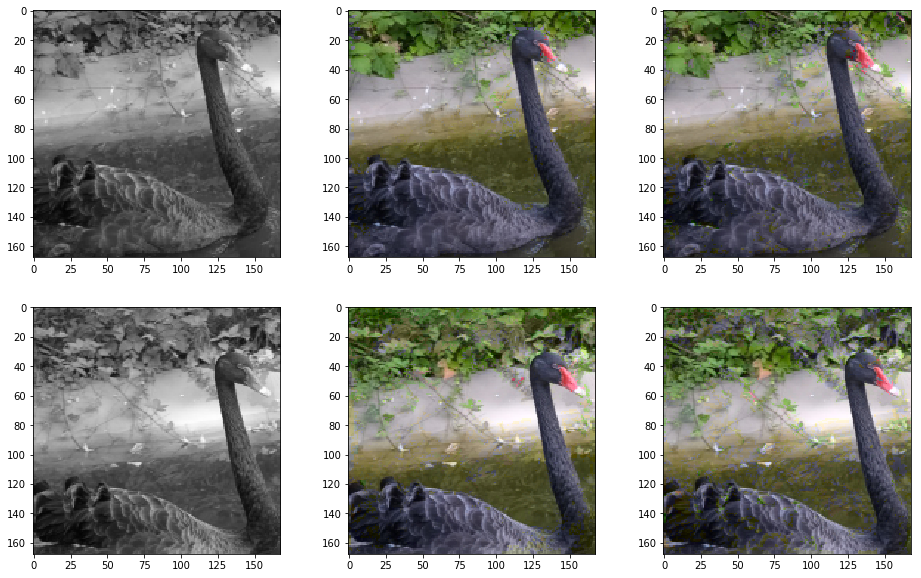

In [274]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
ax[0][0].imshow(rgb2gray(I3))
ax[0][1].imshow(result_3_resnet)
ax[0][2].imshow(result_3_mobilenet)

ax[1][0].imshow(rgb2gray(I20))
ax[1][1].imshow(result_20_resnet)
ax[1][2].imshow(result_20_mobilenet)

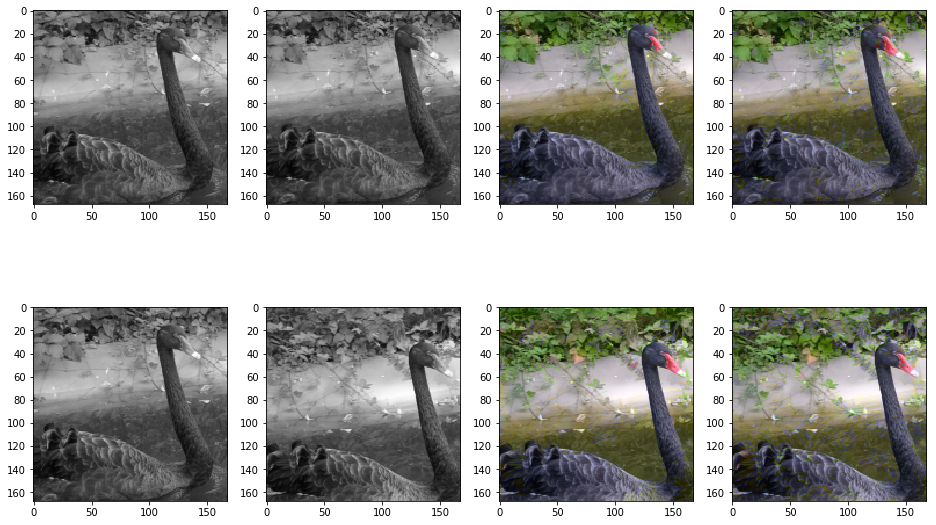

In [275]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))
ax[0][0].imshow(rgb2gray(I1))
ax[0][1].imshow(rgb2gray(I3))
ax[0][2].imshow(result_3_resnet)
ax[0][3].imshow(result_3_mobilenet)

ax[1][0].imshow(rgb2gray(I1))
ax[1][1].imshow(rgb2gray(I20))
ax[1][2].imshow(result_20_resnet)
ax[1][3].imshow(result_20_mobilenet)

In [383]:
refinement_net_mobile = nn.DataParallel(RefinementNet().double().cuda())
refinement_net_mobile.load_state_dict(torch.load("experiments/train_refinement_onepass_six_frames_loss_pretrainetlocal_amsgrad_mobilenet/checkpoints/9800/refinement_net_state_dict"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [432]:
videos_output_mobilenet = []
videos_output_mobilenet_onlyglobal = []
for video_frames in gt_frames:
    _, output_refinement, _, output_global = inference_test_video(video_frames, refinement_net_mobile, local_transfer_net_several_back, global_transferer_mobile,
                                                                                   use_only_local=False)
    videos_output_mobilenet.append(output_refinement)
    videos_output_mobilenet_onlyglobal.append(output_global)
    
    

  0%|          | 0/29 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
  7%|▋         | 2/29 [00:06<01:27,  3.25s/it]/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 5 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
 24%|██▍       | 7/29 [00:19<01:01,  2.80s/it]/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 3 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
 31%|███       | 9/29 [00:24<00:54,  2.72s/it]/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 6 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
 38%|███▊      | 11/29 [00:2

In [404]:
class RefinementNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(9, 64, 3, padding=1, dilation=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=4, dilation=4),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, dilation=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, dilation=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1, dilation=1),
        )
    def forward(self, x):
        return self.conv_layers(x)

In [386]:
refinement_net_resnet = nn.DataParallel(RefinementNet().double().cuda())
refinement_net_resnet.load_state_dict(torch.load("experiments/train_refinement_onepass_six_frames_loss_pretrainetlocal_amsgrad/checkpoints/9800/refinement_net_state_dict"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [433]:
videos_output_resnet = []
videos_output_resnet_onlyglobal = []
for video_frames in gt_frames:
    _, output_refinement, _, output_global = inference_test_video(video_frames, refinement_net_resnet, local_transfer_net_several_back, global_transferer_resnet,
                                                                                   use_only_local=False)
    videos_output_resnet.append(output_refinement)
    videos_output_resnet_onlyglobal.append(output_global)
    
    

 86%|████████▌ | 25/29 [02:40<00:25,  6.41s/it]/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 23 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
100%|██████████| 29/29 [03:10<00:00,  6.56s/it]


In [434]:
gray_gt = []
for i in range(len(gt_frames)):
    gray_gt.append([rgb2gray(frame) for frame in gt_frames[i]]) 

In [446]:
def get_psnr_result(gt_frames, predicted_frames):
    psnr_frames = []
    for i in range(len(gt_frames[0])):
        sliced_gt_frames = [frames[:i + 1] for frames in gt_frames]
        sliced_predicted_frames = [frames[:i + 1] for frames in predicted_frames]
        psnr_frames.append(calculate_psnr_result(sliced_gt_frames, sliced_predicted_frames))
    return psnr_frames

def get_mse_result(gt_frames, predicted_frames):
    mse_frames = []
    for i in tqdm(range(len(gt_frames[0]))):
        sliced_gt_frames = [frames[:i + 1] for frames in gt_frames]
        sliced_predicted_frames = [frames[:i + 1] for frames in predicted_frames]
        mse_frames.append(calculate_mse_lab_result(sliced_gt_frames, sliced_predicted_frames))
    return mse_frames

In [442]:
psnr_refinement_resnet = get_psnr_result(gt_frames, videos_output_resnet)
psnr_refinement_mobilenet = get_psnr_result(gt_frames, videos_output_mobilenet)
psnr_refinement_resnet_onlyglobal = get_psnr_result(gt_frames, videos_output_resnet_onlyglobal)
psnr_refinement_mobilenet_onlyglobal = get_psnr_result(gt_frames, videos_output_mobilenet_onlyglobal)
psnr_gray= get_psnr_result(gt_frames, gray_gt)

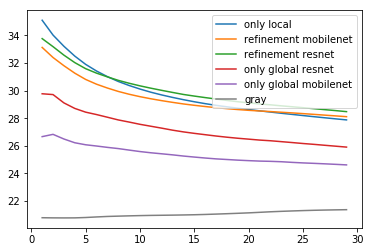

In [444]:
plt.plot(psnr_frames_several_back, label="only local")
plt.plot(psnr_refinement_mobilenet, label="refinement mobilenet")
plt.plot(psnr_refinement_resnet, label="refinement resnet")
plt.plot(psnr_refinement_resnet_onlyglobal, label="only global resnet")
plt.plot(psnr_refinement_mobilenet_onlyglobal, label="only global mobilenet")
plt.plot(psnr_gray, label="gray", color="gray")
plt.legend(loc="best")
plt.show()

In [447]:
mse_refinement_resnet = get_mse_result(gt_frames, videos_output_resnet)
mse_refinement_mobilenet = get_mse_result(gt_frames, videos_output_mobilenet)
mse_refinement_resnet_onlyglobal = get_mse_result(gt_frames, videos_output_resnet_onlyglobal)
mse_refinement_mobilenet_onlyglobal = get_mse_result(gt_frames, videos_output_mobilenet_onlyglobal)
mse_gray= get_mse_result(gt_frames, gray_gt)

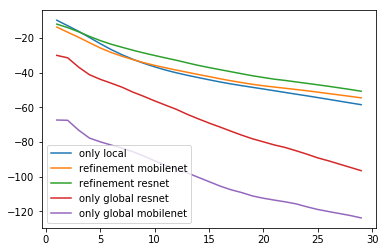

In [448]:
plt.plot(mse_frames_several_back, label="only local")
plt.plot(mse_refinement_mobilenet, label="refinement mobilenet")
plt.plot(mse_refinement_resnet, label="refinement resnet")
plt.plot(mse_refinement_resnet_onlyglobal, label="only global resnet")
plt.plot(mse_refinement_mobilenet_onlyglobal, label="only global mobilenet")
#plt.plot(mse_refinement_gray, label="gray", color="gray")
plt.legend(loc="best")
plt.show()

In [425]:
psnr_refinement_resnet = []
for i in range(len(gt_frames[0])):
    sliced_gt_frames = [frames[:i + 1] for frames in gt_frames]
    sliced_predicted_frames = [frames[:i + 1] for frames in videos_output_resnet]
    psnr_refinement_resnet.append(calculate_psnr_result(sliced_gt_frames, sliced_predicted_frames))
    

psnr_refinement_mobilenet = []
for i in range(len(gt_frames[0])):
    sliced_gt_frames = [frames[:i + 1] for frames in gt_frames]
    sliced_predicted_frames = [frames[:i + 1] for frames in videos_output_mobilenet]
    psnr_refinement_mobilenet.append(calculate_psnr_result(sliced_gt_frames, sliced_predicted_frames))

In [426]:
psnr_gray = []
for i in range(len(gt_frames[0])):
    sliced_gt_frames = [frames[:i + 1] for frames in gt_frames]
    sliced_predicted_frames = [frames[:i + 1] for frames in gray_gt]
    psnr_gray.append(calculate_psnr_result(sliced_gt_frames, sliced_predicted_frames))

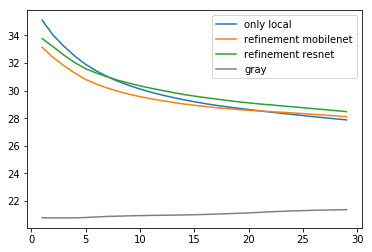

In [427]:
plt.plot(psnr_frames_several_back, label="only local")
plt.plot(psnr_refinement_mobilenet, label="refinement mobilenet")
plt.plot(psnr_refinement_resnet, label="refinement resnet")
plt.plot(psnr_gray, label="gray", color="gray")
plt.legend(loc="best")
plt.show()

In [410]:
mse_refinement_resnet = []
for i in tqdm(range(len(gt_frames[0]))):
    sliced_gt_frames = [frames[:i + 1] for frames in gt_frames]
    sliced_predicted_frames = [frames[:i + 1] for frames in videos_output_resnet]
    mse_refinement_resnet.append(calculate_mse_lab_result(sliced_gt_frames, sliced_predicted_frames))
    

mse_refinement_mobilenet = []
for i in tqdm(range(len(gt_frames[0]))):
    sliced_gt_frames = [frames[:i + 1] for frames in gt_frames]
    sliced_predicted_frames = [frames[:i + 1] for frames in videos_output_mobilenet]
    mse_refinement_mobilenet.append(calculate_mse_lab_result(sliced_gt_frames, sliced_predicted_frames))

In [428]:
mse_refinement_gray = []
for i in tqdm(range(len(gt_frames[0]))):
    sliced_gt_frames = [frames[:i + 1] for frames in gt_frames]
    sliced_predicted_frames = [frames[:i + 1] for frames in gray_gt]
    mse_refinement_gray.append(calculate_mse_lab_result(sliced_gt_frames, sliced_predicted_frames))

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


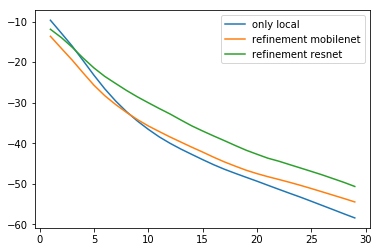

In [430]:
plt.plot(mse_frames_several_back, label="only local")
plt.plot(mse_refinement_mobilenet, label="refinement mobilenet")
plt.plot(mse_refinement_resnet, label="refinement resnet")
#plt.plot(mse_refinement_gray, label="gray", color="gray")
plt.legend(loc="best")
plt.show()

## Optical flow

In [532]:
gt_frames = load_all_test_videos(test_videos_folders, resize_size=(128, 128, 3))
#gt_frames = [frames[:50] for frames in gt_frames]

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [533]:
from src.models import LocalTransferNet, GlobalTransferer, RefinementNet

In [534]:
refinement_mobile = nn.DataParallel(RefinementNet().double().cuda())
refinement_mobile.load_state_dict(torch.load("experiments/train_refinement_onepass_six_frames_loss_pretrainetlocal_amsgrad_mobilenet/checkpoints/9800/refinement_net_state_dict"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [544]:
refinement_mobile_optical = nn.DataParallel(RefinementNet(input_channels=[12, 64, 64, 64, 64, 64]).double().cuda())
refinement_mobile_optical.load_state_dict(torch.load("experiments/train_refinement_onepass_six_frames_loss_pretrainetlocal_amsgrad_mobile_optical_flow/checkpoints/12400/refinement_net_state_dict"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [536]:
#import torch
from pytorch_spynet.run import estimate, Network
optical_flow_net = Network().cuda().eval()
optical_flow_net.load_state_dict(torch.load('pytorch_spynet/network-' + "sintel-final" + '.pytorch'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
videos_output_optical = []
for video_frames in gt_frames:
    _, output_refinement, _, _, _ = inference_test_video(video_frames, refinement_mobile_optical, local_transfer_net_several_back, global_transferer_mobile,
                                                         use_only_local=False,use_optical_flow=True, optical_flow_net=optical_flow_net)
    videos_output_optical.append(output_refinement)
    
    


100%|██████████| 90/90 [04:04<00:00,  2.71s/it]

100%|██████████| 54/54 [02:21<00:00,  2.62s/it]

 24%|██▎       | 14/59 [00:39<02:07,  2.83s/it]


 92%|█████████▏| 54/59 [02:20<00:12,  2.59s/it]

In [538]:
videos_output_mobile = []
for video_frames in gt_frames:
    _, output_refinement, _, _ = inference_test_video(video_frames, refinement_mobile, local_transfer_net_several_back, global_transferer_mobile,
                                                         use_only_local=False,use_optical_flow=False)
    videos_output_mobile.append(output_refinement)
    
    


100%|██████████| 90/90 [02:46<00:00,  1.85s/it]

100%|██████████| 54/54 [01:42<00:00,  1.90s/it]

 24%|██▎       | 14/59 [00:25<01:20,  1.80s/it]


100%|██████████| 59/59 [01:49<00:00,  1.86s/it]

100%|██████████| 69/69 [02:04<00:00,  1.81s/it]

 57%|█████▋    | 45/79 [01:22<01:02,  1.84s/it]


100%|██████████| 79/79 [02:25<00:00,  1.84s/it]


In [539]:
psnr_refinement_mobile_optical = get_psnr_result(gt_frames, videos_output_optical)


In [540]:
psnr_refinement_mobile = get_psnr_result(gt_frames, videos_output_mobile)


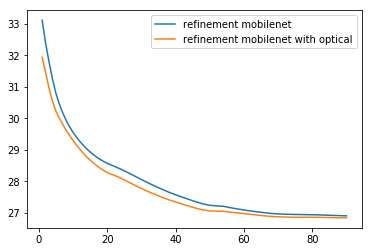

In [543]:
plt.plot(psnr_refinement_mobile, label="refinement mobilenet")
plt.plot(psnr_refinement_mobile_optical, label="refinement mobilenet with optical")
plt.legend(loc="best")

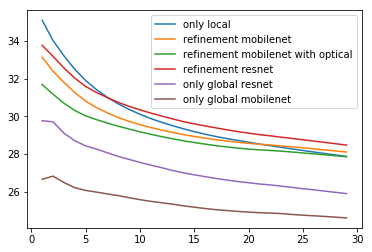

In [469]:
plt.plot(psnr_frames_several_back, label="only local")
plt.plot(psnr_refinement_mobilenet, label="refinement mobilenet")
plt.plot(psnr_refinement_mobile_optical, label="refinement mobilenet with optical")
plt.plot(psnr_refinement_resnet, label="refinement resnet")
plt.plot(psnr_refinement_resnet_onlyglobal, label="only global resnet")
plt.plot(psnr_refinement_mobilenet_onlyglobal, label="only global mobilenet")
plt.legend(loc="best")
plt.show()

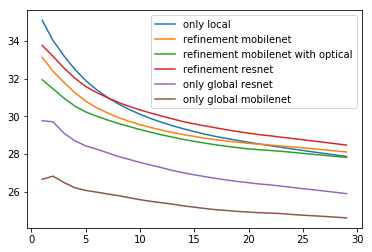

In [485]:
plt.plot(psnr_frames_several_back, label="only local")
plt.plot(psnr_refinement_mobilenet, label="refinement mobilenet")
plt.plot(psnr_refinement_mobile_optical, label="refinement mobilenet with optical")
plt.plot(psnr_refinement_resnet, label="refinement resnet")
plt.plot(psnr_refinement_resnet_onlyglobal, label="only global resnet")
plt.plot(psnr_refinement_mobilenet_onlyglobal, label="only global mobilenet")
plt.legend(loc="best")
plt.show()

In [483]:
mse_refinement_mobilenet_optical = get_mse_result(gt_frames, videos_output_optical)

KeyboardInterrupt: 

In [ ]:
plt.plot(mse_frames_several_back, label="only local")
plt.plot(mse_refinement_mobilenet, label="refinement mobilenet")
plt.plot(mse_refinement_mobilenet_optical, label="refinement mobilenet optical")
plt.plot(mse_refinement_resnet, label="refinement resnet")
plt.plot(mse_refinement_resnet_onlyglobal, label="only global resnet")
plt.plot(mse_refinement_mobilenet_onlyglobal, label="only global mobilenet")
#plt.plot(mse_refinement_gray, label="gray", color="gray")
plt.legend(loc="best")
plt.show()